In [1]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from dateutil.parser import parse

In [256]:
bills_xml = '/Users/zarak/Downloads/download (3).xml'
tree = ET.parse(bills_xml)
root = tree.getroot()

## Features to be extracted
1. BillIntroducedDate
2. ParliamentSession: parliamentNumber
3. ParliamentSession: sessionNumber
4. BillNumber: prefix
5. BillNumber: number
6. BillType
7. SponsorAffiliation.Title
8. SponsorAffiliation.Person: Gender
9. SponsorAffiliation.PoliticalParty
10. PrimeMinister.Person.FullName
11. PrimeMinister.PoliticalParty
12. Statute.Year
13. Statute.Chapter
14. Publications.Publication.PublicationFiles.PublicationFile: relativePath
15. Events.LastMajorStageEvent.Event: chamber
16. Events.LastMajorStageEvent.Event: date
17. Events.LastMajorStageEvent.Event: meetingNumber
18. Events.LastMajorStageEvent.Event.Status.Title
19. Events.LastMajorStageEvent.Event.Progress
20. Events.LegislativeEvents.Event: chamber
21. Events.LegislativeEvents.Event: date
22. Events.LegislativeEvents.Event: meetingNumber
23. Events.LegislativeEvents.Event.Status.Title
24. Events.LegislativeEvents.Event.Progress

## Utility functions

In [582]:
import re
import requests
import PyPDF2
import urllib
from bs4 import BeautifulSoup

def get_bill_urls(root):
    return ['http:'+child.find('Publications').find('Publication').find('PublicationFiles').find('PublicationFile').attrib['relativePath']
             if child.find('Publications').find('Publication') != None else None for child in root]

def get_pdf_urls_bs(bill_urls):
    pdf_urls = []
    for url in bill_urls:
        r = requests.get(url)
        soup = BeautifulSoup(r.content, "lxml")
        pdf_url = soup.find("a", {"class": "btn-export-pdf"})
        pdf_urls.append('http://parl.ca{}'.format(pdf_url.get('href')))
    return pdf_urls


def get_pdf_urls_re(bill_urls):
    pdf_urls = []
    for url in bill_urls:
        if url:
            r = requests.get(url)
            match = re.search(r"href=.*>PDF", r.text)
            pdf_url = r.text[match.start() + 6:match.end() - 5]
            pdf_urls.append('http://parl.ca{}'.format(pdf_url))
        else:
            pdf_urls.append(None)
    return pdf_urls

def get_num_pages(pdf_urls):
    bill_num_pages = []
    for i, url in enumerate(pdf_urls):
        if url:
            bill_pdf, _ = urllib.request.urlretrieve(url, "bill_{}.pdf".format(i))
            reader = PyPDF2.PdfFileReader(open(bill_pdf, 'rb'))
            bill_num_pages.append(reader.getNumPages()) 
            print(reader.getNumPages()) 
        else:
            bill_num_pages.append(None)
    return bill_num_pages

def prepend_feature_name(event_attribs):
    return {'FirstEvent{}'.format(key.capitalize()): value for key, value in event_attribs.items()}

In [281]:
bill_urls = get_bill_urls(root)

In [236]:
pdf_urls = get_pdf_urls_re(bill_urls)

In [419]:
# bill_num_pages = get_num_pages(pdf_urls)

12
20
18


46
84
56
274
40
87
15
8
116
58
8
6
24
36
32
33
26
10
322
198
6
124
35
6
26
294
28
16
22
6
106
32
12
42
26
44
41
10
10
134
30
16
118
197
36
54
100
14
1
8
26
71
944
28
22
18
44
904
28
6
20
44
64
24
8
6
152
551
54
34
28
12
76
54
24
10
59
34
12
6
142
6
1
98
16
38
21
88
66
70
658
6
26
198
40
13
52
18
30
16
40
6
74
20
16
234
190
240
90
30
14
54
24
31
107
12
6
226
6
44
20
6
56
24
10
108
50
14
66
8
10
10
6
48
60
22
12
26
50
20
76
14
8
10
1
6
21
6
184
8
10
1
32
518
252
44
46
40
70
12
66
82
10
84
114
20
200
6
141
6
52
8
48
32
307
15
28
10
6
92
1
36
88
12
10
1
20
32
12
84
28
390
138
8
4
272
56
30
66
16
6
16
244
10
22
32
20
122
20
179
140
380
56
10
6
26
18
21
68
8
16
146
18
8
10
82
109
12
56
10
16
18
1
115
8
38
8
1
1
21
42
50
6
44
42
8
184
96
10
6
16
242
10
88
18
66
452
24
6
96
16
8
14
12
4
1
10
150
16
44
82
4
12
134
6
55
34
114
46
14
4
1
10
28
26
126
6
12
6
1
46
478
22
128
30
10
36
72
14
4
16
50
430
48
63
26
56
40
12
7
60
192
152
22
30
268
962
8
67
16
1
6
28
25
1
1
12
124
56
16
1
152
13
68
74
24


In [442]:
# pd_num_pages = pd.Series(bill_num_pages)
# pd_num_pages.to_csv('bill_num_pages.csv', index=False, na_rep=None)

In [443]:
len(bill_num_pages)
bill_num_pages2 = pd.read_csv('bill_num_pages.csv', header=None)

In [423]:
FIRST_EVENT = 0
LAST_EVENT = -1
start_dates = pd.to_datetime([parse(bill.find('Events').find('LegislativeEvents')[FIRST_EVENT].attrib['date']) for bill in root])
end_dates = pd.to_datetime([parse(bill.find('Events').find('LegislativeEvents')[LAST_EVENT].attrib['date']) for bill in root])
days_until_royal_assent = (end_dates - start_dates).days

(array([ 116.,   50.,   53.,   43.,   41.,   26.,   30.,   31.,   27.,
          16.,    5.,    9.,   20.,   23.,   18.,    4.,    4.,    3.,
           4.,    1.,   10.]),
 array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
        390, 420, 450, 480, 510, 540, 570, 600, 630]),
 <a list of 21 Patch objects>)

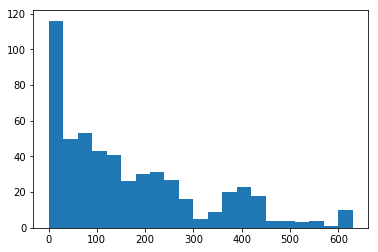

In [424]:
plt.hist(days_until_royal_assent, bins=range(0, 660, 30))

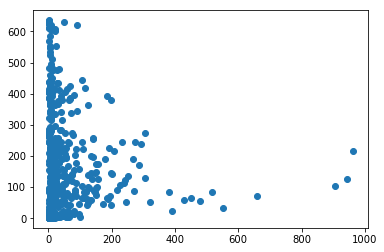

In [427]:
plt.scatter(bill_num_pages, int_days_till_ra)

## Create pandas DataFrame of all features

In [605]:
# Some additional features added: id, title, urls, number of pages
observations = []
for i, bill in enumerate(root):
    observation = dict()
    observation[bill.find('BillIntroducedDate').tag] = bill.find('BillIntroducedDate').text
    observation['BillID'] = bill.attrib['id']
    observation['BillTitle'] = bill.find('BillTitle').find('Title').text
    observation['ParliamentNumber'] = bill.find('ParliamentSession').attrib['parliamentNumber']
    observation['SessionNumber'] = bill.find('ParliamentSession').attrib['sessionNumber']
    observation['BillNumber'] = '{}-{}'.format(bill.find('BillNumber').attrib['prefix'], bill.find('BillNumber').attrib['number'])
    observation['BillType'] = bill.find('BillType').find('Title').text
    observation['SponsorTitle'] = bill.find('SponsorAffiliation').find('Title').text
    observation['SponsorGender'] = bill.find('SponsorAffiliation').find('Person').attrib['Gender']
    observation['SponsorParty'] = bill.find('SponsorAffiliation').find('PoliticalParty').find('Title').text
    observation['PrimeMinisterName'] = bill.find('PrimeMinister').find('Person').find('FullName').text
    observation['PrimeMinisterParty'] = bill.find('PrimeMinister').find('PoliticalParty').find('Title').text
    observation['StatuteYear'] = bill.find('Statute').find('Year').text
    observation['StatuteChapter'] = bill.find('Statute').find('Chapter').text
    observation['LastEventDate'] = bill.find('Events').find('LastMajorStageEvent').find('Event').attrib['date']
    # Access by index from arrays
    observation['BillNumberOfPages'] = bill_num_pages[i]
    observation['BillURL'] = bill_urls[i]
    observation['PDFURL'] = pdf_urls[i]
    observation['DaysUntilRoyalAssent'] = days_until_royal_assent[i]
    
    first_event_details = prepend_feature_name(bill.find('Events').find('LegislativeEvents')[FIRST_EVENT].attrib)
    
    observation.update(first_event_details)
    
    observations.append(observation)

In [607]:
observation

{'BillID': '5493462',
 'BillIntroducedDate': '2012-04-02T00:00:00',
 'BillNumber': 'S-1003',
 'BillNumberOfPages': 6,
 'BillTitle': 'An Act to authorize Industrial Alliance Pacific Insurance and Financial Services Inc. to apply to be continued as a body corporate under the laws of Quebec',
 'BillType': 'Senate Private Bill',
 'BillURL': 'http://parl.ca/DocumentViewer/en/5500806?Language=E',
 'DaysUntilRoyalAssent': 45,
 'FirstEventChamber': 'SEN',
 'FirstEventDate': '2012-04-02',
 'FirstEventId': '7282392',
 'FirstEventMeetingnumber': '66',
 'LastEventDate': '2012-05-17',
 'PDFURL': 'http://parl.ca/Content/Bills/411/Private/S-1003/S-1003_1/S-1003_1.PDF',
 'ParliamentNumber': '41',
 'PrimeMinisterName': 'Stephen Harper',
 'PrimeMinisterParty': 'Conservative',
 'SessionNumber': '1',
 'SponsorGender': 'M',
 'SponsorParty': 'Conservative',
 'SponsorTitle': 'Senator',
 'StatuteChapter': '32',
 'StatuteYear': '2012'}

In [608]:
data = pd.DataFrame(observations)

In [609]:
data.to_csv('parliament.csv', index=False)

In [610]:
df = pd.read_csv('parliament.csv')

In [611]:
df

,BillID,BillIntroducedDate,BillNumber,BillNumberOfPages,BillTitle,BillType,BillURL,DaysUntilRoyalAssent,FirstEventChamber,FirstEventDate,...,PDFURL,ParliamentNumber,PrimeMinisterName,PrimeMinisterParty,SessionNumber,SponsorGender,SponsorParty,SponsorTitle,StatuteChapter,StatuteYear
0,8062279,2015-12-09T15:56:00,C-2,12.0,An Act to amend the Income Tax Act,House Government Bill,http://parl.ca/DocumentViewer/en/8064766?Langu...,372,HOC,2015-12-09,...,http://parl.ca/Content/Bills/421/Government/C-...,42,Justin Trudeau,Liberal,1,M,Liberal,Minister of Finance,11,2016
1,6254806,2013-10-17T10:09:54,C-2,20.0,An Act to amend the Controlled Drugs and Subst...,House Government Bill,http://parl.ca/DocumentViewer/en/6256959?Langu...,609,HOC,2013-10-17,...,http://parl.ca/Content/Bills/412/Government/C-...,41,Stephen Harper,Conservative,2,F,Conservative,Minister of Health,22,2015
2,5085519,2011-06-13T15:03:53,C-2,18.0,An Act to amend the Criminal Code (mega-trials),House Government Bill,http://parl.ca/DocumentViewer/en/5087405?Langu...,13,HOC,2011-06-13,...,http://parl.ca/Content/Bills/411/Government/C-...,41,Stephen Harper,Conservative,1,M,Conservative,Minister of Justice,16,2011
3,4333701,2010-03-10T15:12:16,C-2,46.0,An Act to implement the Free Trade Agreement b...,House Government Bill,http://parl.ca/DocumentViewer/en/4338392?Langu...,111,HOC,2010-03-10,...,http://parl.ca/Content/Bills/403/Government/C-...,40,Stephen Harper,Conservative,3,M,Conservative,Minister of International Trade,4,2010
4,3628710,2009-01-28T15:06:58,C-2,84.0,An Act to implement the Free Trade Agreement b...,House Government Bill,http://parl.ca/DocumentViewer/en/3632502?Langu...,91,HOC,2009-01-28,...,http://parl.ca/Content/Bills/402/Government/C-...,40,Stephen Harper,Conservative,2,M,Conservative,Minister of International Trade and Minister f...,6,2009
5,3076458,2007-10-18T10:05:52,C-2,56.0,An Act to amend the Criminal Code and to make ...,House Government Bill,http://parl.ca/DocumentViewer/en/3078412?Langu...,133,HOC,2007-10-18,...,http://parl.ca/Content/Bills/392/Government/C-...,39,Stephen Harper,Conservative,2,M,Conservative,Minister of Justice,6,2008
6,2158135,2006-04-11T10:06:18,C-2,274.0,An Act providing for conflict of interest rule...,House Government Bill,http://parl.ca/DocumentViewer/en/2333855?Langu...,245,HOC,2006-04-11,...,http://parl.ca/Content/Bills/391/Government/C-...,39,Stephen Harper,Conservative,1,M,Conservative,President of the Treasury Board,9,2006
7,1395588,2004-10-08T12:16:21,C-2,40.0,An Act to amend the Criminal Code (protection ...,House Government Bill,http://parl.ca/DocumentViewer/en/2334051?Langu...,285,HOC,2004-10-08,...,http://parl.ca/Content/Bills/381/Government/C-...,38,Paul Martin,Liberal,1,M,Liberal,Minister of Justice,32,2005
8,508919,2002-10-03T13:41:15,C-2,87.0,An Act to establish a process for assessing th...,House Government Bill,http://parl.ca/DocumentViewer/en/2331362?Langu...,222,HOC,2002-10-03,...,http://parl.ca/Content/Bills/372/Government/C-...,37,Jean Chrétien,Liberal,2,M,Liberal,Minister of Indian Affairs and Northern Develo...,7,2003
9,9992,2001-02-02T14:00:11,C-2,15.0,An Act to amend the Employment Insurance Act a...,House Government Bill,http://parl.ca/DocumentViewer/en/2330900?Langu...,97,HOC,2001-02-02,...,http://parl.ca/Content/Bills/371/Government/C-...,37,Jean Chrétien,Liberal,1,F,Liberal,Minister of Human Resources Development,5,2001
